## Classical simulation of DMERA

For the simulation without noise, **tensor contraction** is used 

For the simulation with noise, **Kraus operators** are used. Noise models: depolarizing, 2-qubit gate infidelity (var)

    

This notebook produces:
- Plots for eigenvalues: [noiseless D=2, noiseless D=4] and [exact, noiseless D=2, noisy depol, noisy var]
- Plots for energies
- Plot for decay of noise after a single noisy layer
- Datafiles with observable decay curves for all observables \in {X, Y, Z}^3


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy import sparse
from enum import Enum
from time import perf_counter
import sys
import functools
import itertools
import csv
import copy

import native_gate_decomp as ngd

## Definitions

In [2]:
pi = np.pi

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = 1j * X @ Z
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
P = np.array([[1, 0], [0, 1j]])

def kron(*args):
    assert len(args) >= 1
    X = args[0]
    for Y in args[1:]:
        X = np.kron(X, Y)
    return X

def basis_vec(i,d):
    vec = np.array([[0] for k in range(d)])
    vec[i] = 1
    return vec

def make_w(theta):
    return np.array(
        [
            [np.cos(theta - np.pi / 4), 0, 0, np.sin(theta - np.pi / 4)],
            [0, np.cos(np.pi / 4), -np.sin(np.pi / 4), 0],
            [0, np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
            [-np.sin(theta - np.pi / 4), 0, 0, np.cos(theta - np.pi / 4)],
        ]
    )


def make_u(theta):
    return np.array(
        [
            [np.cos(theta), 0, 0, np.sin(theta)],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [-np.sin(theta), 0, 0, np.cos(theta)],
        ]
    )

ket0 = np.array([[1.], [0.]])
bra0 = ket0.conj().transpose()

ket1 = np.array([[0.], [1.]])
bra1 = ket1.conj().transpose()

# qubit stabilizer states
rho_x = (I + X)/2
rho_y = (I + Y)/2
rho_zp = (I + Z)/2
rho_zm = (I - Z)/2

## Setup gates

In [3]:
theta1 = np.pi / 12
theta2 = -np.pi / 6

# general contraction scheme for grouped unitaries w and u
def contract_TN(w, u):
    # upper half of channel
    omega = np.einsum("ilm,mjnp,kno->ijklpo", w, u, w)

    # average over leftmost and rightmost qubit
    # keep same shape except for splitting the to-be-traced qubit 
    sh = omega.shape
    omega = omega.reshape(sh[0], sh[1], sh[2], sh[3], int(sh[4]/2), 2, sh[-1])
    phi_l = np.einsum("ijklpso,osPlzyx->ijkpPxyz", omega, omega.conj().T, optimize=True)
    
    omega = omega.reshape(sh[0], sh[1], sh[2], sh[3], 2, int(sh[4]/2), sh[-1])
    phi_r = np.einsum("ijklpqo,oQplzyx->ijkqQxyz", omega, omega.conj().T, optimize=True)
    
    phi = 1/2 * (phi_l + phi_r)
    return phi

@functools.lru_cache(256)
def assign_gates(decomp, var=0.112, p=0.0087):
    if decomp == "var":
        w = ngd.W_decomp_var(theta1, var)
        u = ngd.U_decomp_var(theta2, var)
        w_layer = [kron(a, b, c) for a in w for b in w for c in w] # Composite Kraus ops
        u_layer = [kron(d, e) for d in u for e in u] # Composite Kraus ops
        
    elif decomp == "depol":
        w_layer = ngd.W_decomp_depol_layer
        u_layer = ngd.U_decomp_depol_layer

    else:
        raise ValueError("Did not recognize the decomposition. Choose from [var, depol]")
    
    return w_layer, u_layer

In [4]:
def renormalize_once(rho, keep_left, decomp, var, p):
    """Apply a single renormalization layer (in the Schrodinger picture)."""
    
    w_layer, u_layer = assign_gates(decomp, var)

    # add |0><0| on every second site
    rho = kron(ket0, I, ket0, I, ket0, I) @ rho @ kron(bra0, I, bra0, I, bra0, I)

    # act by W \ot W \ot W
    if decomp == "var":
        new_rho = np.zeros((64,64)).astype(complex)
        for X in w_layer:
            new_rho += X @ rho @ X.conj().transpose()
        rho = new_rho
    else:
        rho = w_layer(rho, theta1, p)

    # partial trace over leftmost and rightmost qubit
    rho = np.einsum("abcaBc->bB", rho.reshape(2, 16, 2, 2, 16, 2))
    
    # act by U \ot U
    if decomp == "var":
        new_rho = np.zeros((16, 16)).astype(complex)
        for Y in u_layer:
            new_rho += Y @ rho @ Y.conj().transpose()
        rho = new_rho
    else:
        rho = u_layer(rho, theta2, p)
    
    # partial trace over rightmost or leftmost qubit
    if keep_left:
        rho = np.einsum("abAb->aA", rho.reshape(8, 2, 8, 2))
    else:
        rho = np.einsum("abaB->bB", rho.reshape(2, 8, 2, 8))
    
    return np.real(rho)

Mode = Enum("Mode", "KEEP_LEFT KEEP_RIGHT AVERAGE")

def prepare_state(num_layers, rho, mode, decomp, var, p):

    # apply renormalization layers
    for _ in range(num_layers):
        if mode == Mode.AVERAGE:
            rho_left = renormalize_once(rho, keep_left=True, decomp=decomp, var=var, p=p)
            rho_right = renormalize_once(rho, keep_left=False, decomp=decomp, var=var, p=p)
            rho = 1 / 2 * rho_left + 1 / 2 * rho_right
        else:
            keep_left = mode == Mode.KEEP_LEFT
            rho = renormalize_once(rho, keep_left=keep_left, decomp=decomp, var=var, p=p)

    return rho

In [38]:
def comp_matrix_rep(decomp, var=0.112, p=0.0087):
    d = 2**3   # 3 qubits
    M = np.zeros((d**2,d**2))

    for i in range(d):
        for j in range(d):
            # single channel operation only changes for (i,j)
            basis_matrix = basis_vec(i, d) @ basis_vec(j, d).conj().transpose()
            single_operation = prepare_state(1, basis_matrix, mode=Mode.AVERAGE, decomp=decomp, var=var, p=p)

            for k in range(d):
                for l in range(d):
                    M[d*k+l][d*i+j] = basis_vec(k, d).conj().transpose() @ single_operation @ basis_vec(l, d)

    print("Finished with", decomp)
    return M

## Tensor contraction for D = 2 and D = 4

In [5]:
### D = 2 ###

# prepare w and u tensors
w = np.einsum("klij,i->jkl", make_w(pi/12).reshape(2,2,2,2), ket0.reshape(-1))
reshaped_u = np.einsum("klij->ijkl", make_u(-pi/6).reshape(2,2,2,2))
u = np.einsum("jlm,ilno,mkpq->ijknopq", w, reshaped_u, reshaped_u).reshape(2,2,2,16)

psi_D2 = contract_TN(w,u)
psi_matrix_D2 = np.einsum("ijkl->iljk", psi_D2.reshape(2**3,2**3,2**3,2**3)).reshape(2**6,2**6)

In [56]:
### D = 4 ###
# WARNING: can take ~2 mins to complete

# prepare w and u1,u2,u3 tensors
w0 = np.einsum("klij,i->jkl", make_w(0.276143653403021).reshape(2,2,2,2), ket0.reshape(-1)) # w + initialized |0> state
u1 = np.einsum("klij->ijkl", make_u(0.950326554644286).reshape(2,2,2,2))
u2 = np.einsum("klij->ijkl", make_u(-0.111215262156182).reshape(2,2,2,2))
u3 = np.einsum("klij->ijkl", make_u(-pi/2).reshape(2,2,2,2))

w = np.einsum("ilm,jno,kpq,mnrs,optu,stvw->ijklrvwuq", w0, w0, w0, u1, u1, u2).reshape(8,8,8)
u = np.einsum("lpq,kprs,qmtu,jrvw,stxy,unzA,ivBC,wxDE,yzFG,AoHI->ijklmnoBCDEFGHI", w0, u1, u1, u2, u2, u2, u3, u3, u3, u3)
u = u.reshape(8,2,8,2**8)

psi_D4 = contract_TN(w,u)
psi_D4 = psi_D4.reshape(2**7,2**7,2**7,2**7)
psi_matrix_D4 = np.einsum("ijkl->iljk", psi_D4.reshape(2**7,2**7,2**7,2**7)).reshape(2**14,2**14)


## Compute eigenvalues

In [39]:
# prepare noisy matrices to diagonalize
var = 0.112
p = 0.0087
M_var = comp_matrix_rep(decomp="var", var=var)
M_depol = comp_matrix_rep(decomp="depol",  p=p)

Finished with var
Finished with depol


In [57]:
eig_decomp_D2 = scipy.linalg.eig(psi_matrix_D2, left=True, right=True)
evals_D2 = eig_decomp_D2[0]
scaling_dims_D2 = -np.log2(np.abs(evals_D2))
scaling_dims_D2.sort()

evals_var = scipy.linalg.eig(M_var)[0]
scaling_dims_var = -np.log2(np.abs(evals_var))
scaling_dims_var.sort()

evals_depol = scipy.linalg.eig(M_depol)[0]
scaling_dims_depol = -np.log2(np.abs(evals_depol))
scaling_dims_depol.sort()

scaling_dims_exact = [0, 0.125, 1, 1.125, 1.125, 2, 2, 2, 2, 2.125, 2.125, 2.125, 3, 3, 3, 3, 3, \
                        3.125, 3.125, 3.125, 3.125, 3.125, 3.125, 4, 4, 4, 4, 4, 4, 4, 4, 4]
print(scaling_dims_D2[:6])

[-6.40685301e-16  1.40249748e-01  1.00000000e+00  1.13592045e+00
  1.15004706e+00  2.00000000e+00]


In [58]:
sparse_psi_D4 = sparse.csc_matrix(psi_matrix_D4)
evals_D4 = scipy.sparse.linalg.eigs(sparse_psi_D4, k=32)[0]
scaling_dims_D4 = -np.log2(np.abs(evals_D4))
scaling_dims_D4.sort()


## Plot eigenvalues

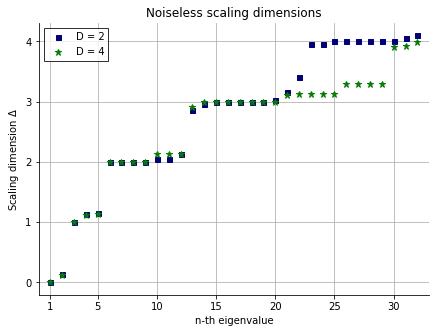

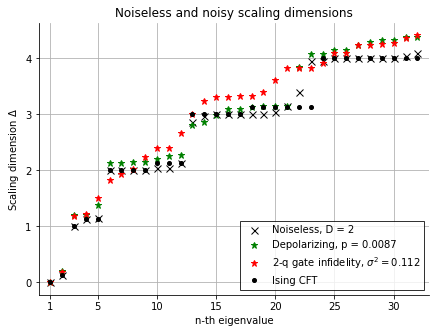

In [61]:
def plot_scaling_dims_exact():
    fig, ax = plt.subplots()

    plt.plot(range(1,33), scaling_dims_D2[:32], marker="s", markersize=5, \
            linewidth=0, color="navy", label="D = 2")
    plt.plot(range(1,33), scaling_dims_D4, marker="*", markersize=7, \
            linewidth=0, color="green", label="D = 4")

    plt.legend(fancybox=False, edgecolor="black")
    plt.xlabel("n-th eigenvalue")
    plt.ylabel(r"Scaling dimension $\Delta$")
    plt.title("Noiseless scaling dimensions")
    plt.grid()
    plt.xlim(0, 33)
    plt.xticks([1,5,10,15,20,25,30])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.set_size_inches(7, 5)
    plt.savefig("./jupyter_figs/scaling_dims_D2_D4.pdf", bbox_inches="tight")
    plt.show()

#########################

def plot_scaling_dims_noise():
    fig, ax = plt.subplots()

    plt.plot(range(1,33), scaling_dims_D2[:32], "x", markersize = 7, linewidth = 0, \
            color = "black", label="Noiseless, D = 2")
    plt.plot(range(1,33), scaling_dims_depol[:32], "*", markersize = 7, linewidth = 0, \
            color = "green", label="Depolarizing, p = "+str(p))
    plt.plot(range(1,33), scaling_dims_var[:32], "*", markersize = 7, linewidth = 0, \
            color = "red", label=r"2-q gate infidelity, $\sigma^2 =$"+str(var))
    plt.plot(range(1,33), scaling_dims_exact, "o", markersize=4, linewidth=0, \
            color="black", label="Ising CFT")

    plt.legend(loc="lower right", fancybox=False, edgecolor="black")
    plt.xlabel("n-th eigenvalue")
    plt.ylabel(r"Scaling dimension $\Delta$")
    plt.title("Noiseless and noisy scaling dimensions")
    plt.grid()
    plt.xlim(0, 33)
    plt.xticks([1,5,10,15,20,25,30])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.set_size_inches(7, 5)
    plt.savefig("./jupyter_figs/scaling_dims.pdf", format="pdf", bbox_inches="tight")
    plt.savefig("./jupyter_figs/scaling_dims.jpg", format="jpg", bbox_inches="tight", dpi=300)

    plt.show()

plot_scaling_dims_exact()
plot_scaling_dims_noise()

## Compute energies

In [40]:
# generate list of energies up to m layers
def energies_layers(m, decomp, D=2):
    energies = []
    start_rho = kron(ket0, ket0, ket0) @ kron(bra0, bra0, bra0)

    for k in range(m+1):
        rho = start_rho

        if decomp == "exact":
            if D == 2:
                for _ in range(k):
                    rho = np.einsum("ijkpPwux,ijkwux", psi_D2, rho.reshape(2,2,2,2,2,2))
                rho = rho.reshape(8,8)
            elif D == 4:
                rho = kron(ket0, ket0, ket0, ket0, ket0, ket0, ket0) \
                    @ kron(bra0, bra0, bra0, bra0, bra0, bra0, bra0)
                for _ in range(k):
                    rho = np.einsum("ijkl,il->jk", psi_D4.reshape(128,128,128,128), rho)
            
        else:
            rho = prepare_state(num_layers=k, rho=start_rho, decomp=decomp, var=0.112, p=0.0087, \
                                mode=Mode.AVERAGE)
        
        if D == 2:
            E_XZX = np.trace(kron(X, Z, X) @ rho)
            E_XXI = np.trace(kron(I, X, X) @ rho)
            E_IXX = np.trace(kron(X, X, I) @ rho)
        elif D == 4:
            E_XZX = np.trace(kron(I, I, X, Z, X, I, I) @ rho)
            E_XXI = np.trace(kron(I, I, I, X, X, I, I) @ rho)
            E_IXX = np.trace(kron(I, I, X, X, I, I, I) @ rho)
        E_numpy = np.real(E_XZX - (E_IXX + E_XXI) / 2)
        energies.append(round(E_numpy,6))
    return energies

In [63]:
# generate lists of energies
layers = 5
exact_D2_energies = energies_layers(layers, decomp="exact", D=2)
# exact_D4_energies = energies_layers(layers, decomp="exact", D=4)
depol_energies = energies_layers(layers, decomp="depol")
var_energies = energies_layers(layers, decomp="var")

print(f"Converged energies after {layers} layers:")
print(f"D = 2: {exact_D2_energies[-1]}")
# print(f"D = 4: {exact_D4_energies[-1]}")
print(f"depol: {depol_energies[-1]}")
print(f"var: {var_energies[-1]}")

print(exact_D2_energies)

Converged energies after 5 layers:
D = 2: -1.240916
D = 4: -1.26635
depol: -1.083358
var: -1.08286
[0.0, -0.916266, -1.15922, -1.22132, -1.236984, -1.240916]


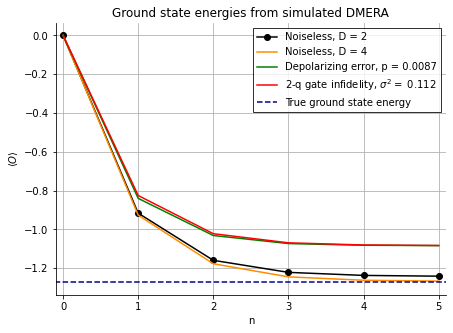

In [65]:
# plot energies
fig, ax = plt.subplots()

plt.plot(exact_D2_energies, label="Noiseless, D = 2", \
            color="black", marker="o")
plt.plot(exact_D4_energies, label="Noiseless, D = 4", \
            color="darkorange")
plt.plot(depol_energies, label=f"Depolarizing error, p = {p}", \
            color="green")
plt.plot(var_energies, label=rf"2-q gate infidelity, $\sigma^2 =$ {var}", \
            color="red")
plt.hlines(y=-4/pi, xmin=-1, xmax=layers+1, color="darkblue", linestyle="--", \
            label="True ground state energy")

plt.legend(fancybox=False, edgecolor="black")
plt.xlabel("n")
plt.ylabel("Energy (a.u.)")
plt.ylabel(r"$\langle O \rangle$")
plt.title("Ground state energies from simulated DMERA")
# plt.title("Decay of observable")
plt.grid()
plt.xlim(-0.1, layers+0.1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.set_size_inches(7, 5)
plt.savefig("./jupyter_figs/dmera_energies.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("./jupyter_figs/dmera_energies.jpg", format="jpg", bbox_inches="tight", dpi=300)
plt.show()

## Decay of noise after a single noisy layer

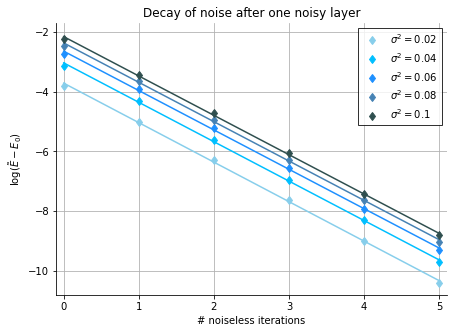

In [55]:
# recreate fig 5
E_expected = -4/np.pi
fig, ax = plt.subplots()
colors = ["skyblue", "deepskyblue", "dodgerblue", "steelblue", "darkslategrey"]

for i, variance in enumerate([0.02, 0.04, 0.06, 0.08, 0.1]):
    decay = []
    start_rho = kron(ket0, ket0, ket0) @ kron(bra0, bra0, bra0)
    for _ in range(10):
        start_rho = np.einsum("ijkpPwux,ijkwux", psi_D2, start_rho.reshape(2,2,2,2,2,2))
    E_XZX = np.trace(kron(X, Z, X) @ start_rho)
    E_XXI = np.trace(kron(I, X, X) @ start_rho)
    E_IXX = np.trace(kron(X, X, I) @ start_rho)
    E_exact = E_XZX - (E_IXX + E_XXI) / 2
    rho_noise = prepare_state(num_layers=1, rho=start_rho, decomp="var", var=variance, p=0, mode=Mode.AVERAGE)

    for n in range(6):
        E_XZX = np.trace(kron(X, Z, X) @ rho_noise)
        E_XXI = np.trace(kron(I, X, X) @ rho_noise)
        E_IXX = np.trace(kron(X, X, I) @ rho_noise)
        E_noise = E_XZX - (E_IXX + E_XXI) / 2 
        # print(f"E_noise = {E_noise}")
        # print(f"E_exact = {E_exact}")
        decay.append(np.log(E_noise - E_exact))
        
        rho_noise = np.einsum("ijkpPwux,ijkwux", psi_D2, rho_noise.reshape(2,2,2,2,2,2))
    
    x = range(6)
    m, b = np.polyfit(x, decay, deg = 1)
    fit, = plt.plot(x, m*x + b, color=colors[i])
    plt.plot(x, decay, marker="d", linewidth = 0, label=r"$\sigma^2 =$"+str(variance), color = fit.get_color())

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.set_size_inches(7, 5)
plt.title("Decay of noise after one noisy layer")
plt.xlabel("# noiseless iterations")
plt.ylabel(r"log($\tilde{E} - E_0)$")
plt.yticks([-10, -8, -6, -4, -2])
plt.xlim(-0.1, 5+0.1)
plt.ylim(-10.8, -1.7)
plt.legend(fancybox=False, edgecolor="black")
plt.grid()
plt.savefig("./jupyter_figs/noise_decay.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("./jupyter_figs/noise_decay.jpg", format="jpg", bbox_inches="tight", dpi=300)
plt.show()

## Compute observable decay curves

In [15]:
# Compute decay curve until convergence for a given qubit stabilizers starting state and observable
def compute_decay(state_l, obs_str, decomp, var=0.112, p=0.0087):
    
    # Relate input state (list) to starting state
    state_poss_l = ["x", "y", "zp", "zm"]
    state_poss = [rho_x, rho_y, rho_zp, rho_zm]
    
    m0 = state_poss_l.index(state_l[0])
    m1 = state_poss_l.index(state_l[1])
    m2 = state_poss_l.index(state_l[2])
    starting_state = kron(state_poss[m0], state_poss[m1], state_poss[m2])
    
    # Relate input obs (string) to obs
    obs_poss_str = ["X", "Y", "Z"]
    obs_poss = [X, Y, Z]
    
    n0 = obs_poss_str.index(obs_str[0])
    n1 = obs_poss_str.index(obs_str[1])
    n2 = obs_poss_str.index(obs_str[2])
    obs = kron(obs_poss[n0], obs_poss[n1], obs_poss[n2])
    
    obs_decay = np.array([])
    k = 0
    meanchanges = 1
    rho = starting_state
    # Convergence when relative difference < 0.02 or after 30 layers
    while meanchanges > 0.02 and k < 30:
        
        # Compute layer for layer until convergence (or 30 layers)
        if decomp == "exact":
            rho = np.einsum("ijkl,il->jk", psi_D2.reshape(8,8,8,8), rho)
        else:
            rho_left = renormalize_once(rho, keep_left=True, decomp=decomp, var=var, p=p)
            rho_right = renormalize_once(rho, keep_left=False, decomp=decomp, var=var, p=p)
            rho = 1 / 2 * rho_left + 1 / 2 * rho_right
        obs_decay = np.append(obs_decay, round(np.real(np.trace(obs @ rho)),6))
        
        # Start with 3 values in energies before checking for convergence
        if len(obs_decay) > 3:
            obs_decay = np.array(obs_decay)
            rel_diff = abs((obs_decay[1:] - obs_decay[:-1]) / obs_decay[1:])
            meanchanges = np.mean(rel_diff[-3:])

        k += 1
        
    return obs_decay


# Create file with observable decay data for all possible qubit stabilizer starting states for a given observable
def create_decay_datafile(obs, decomp, var=0.112, p=0.0087):
    
    # List of all possible starting states in the form of rho = A x B x C
    starting_states = list(itertools.product(["x", "y", "zp", "zm"], repeat = 3))
    
    if decomp == "depol":
        filename = f"./observable_data/{obs}_data_{decomp}_{p}.csv"
    elif decomp == "var":
        filename = f"./observable_data/{obs}_data_{decomp}_{var}.csv"
    elif decomp == "exact":
        filename = f"./observable_data/{obs}_data_exact.csv"
    else:
        raise ValueError("Input a valid decomposition.")
    
    with open(filename, "w", newline="") as f:
        cw = csv.writer(f)
        for state in starting_states:
            E = compute_decay(state, obs, decomp, var, p)
            
            # if E contains only zeros, do not add to file
            if not all(E == 0):
                cw.writerow(list(state) + list(E))


def create_all_decay_files(decomp, var=0.112, p=0.0087):
    pauli_observables = ["X", "Y", "Z"]

    for combi in itertools.product(pauli_observables, repeat=3):
        obs = "".join(combi)
        create_decay_datafile(obs, decomp, var=var, p=p)

In [18]:
# compute_decay(["x", "x", "zm"],  "YZY", decomp="exact")
create_all_decay_files(decomp="exact")

C:\Users\Bjarne\AppData\Local\Temp\ipykernel_12656\2753971987.py:41: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = abs((obs_decay[1:] - obs_decay[:-1]) / obs_decay[1:])
C:\Users\Bjarne\AppData\Local\Temp\ipykernel_12656\2753971987.py:41: RuntimeWarning: divide by zero encountered in true_divide
  rel_diff = abs((obs_decay[1:] - obs_decay[:-1]) / obs_decay[1:])
